# Продвинутые темы

Здесь мы рассмотрим несколько концепций, которые являются логическим продолжением основ и часто встречаются в более сложных статистических моделях и алгоритмах машинного обучения, но часто кажущиеся абстрактными: Дельта-метод и Производящую функцию моментов (MGF).

## Дельта-метод: Эффект домино для ошибок

Представьте, что вы измеряете сторону квадрата. Ваше измерение не идеально и имеет некоторую погрешность (ошибку). Теперь вы хотите посчитать **площадь** этого квадрата. Логично, что у посчитанной площади тоже будет ошибка.

> **Дельта-метод — это способ оценить ошибку результата, зная ошибку исходных данных.**

Он работает как эффект домино: маленькое "колебание" на входе (в измерении стороны) приводит к предсказуемому "колебанию" на выходе (в площади).

### Практический пример: Измерение скорости по GPS

Представим, что GPS-трекер в машине каждую секунду сообщает свои координаты. Эти измерения не идеальны и имеют небольшую случайную ошибку, которая распределена нормально.
*   Мы хотим посчитать **скорость** машины. Для этого мы берем расстояние между двумя последовательными точками и делим на время (1 секунда).

**Вопрос:** Если ошибка в координатах распределена нормально, то каким будет распределение ошибки в посчитанной скорости?

Давайте симулируем это.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42) # для воспроизводимости

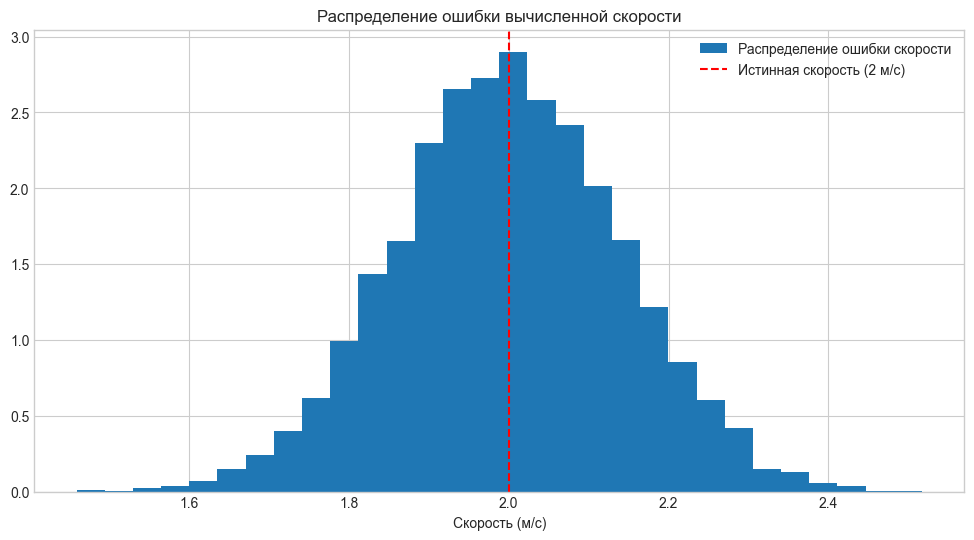

Средняя посчитанная скорость: 1.9998 м/с
Стандартное отклонение ошибки скорости: 0.1409 м/с


In [2]:
# Симулируем "истинное" движение машины
true_position = np.arange(0, 100, 2) # Каждую секунду машина проезжает 2 метра

# Симулируем 10000 "зашумленных" измерений для каждой точки
# Ошибка измерения распределена нормально со средним 0 и ст. отклонением 0.1м
n_simulations = 10000
error = np.random.normal(loc=0, scale=0.1, size=(len(true_position), n_simulations))
measured_position = true_position[:, np.newaxis] + error

# Рассчитываем 10000 "зашумленных" скоростей
# Скорость = (Позиция(t) - Позиция(t-1)) / 1 секунда
measured_speeds = measured_position[1:, :] - measured_position[:-1, :]
# Возьмем скорости в середине пути для примера
sample_of_speeds = measured_speeds[25, :]

# Визуализация
plt.figure(figsize=(12, 6))
plt.hist(sample_of_speeds, bins=30, density=True, label='Распределение ошибки скорости')
plt.axvline(2.0, color='red', linestyle='--', label='Истинная скорость (2 м/с)')
plt.title('Распределение ошибки вычисленной скорости')
plt.xlabel('Скорость (м/с)')
plt.legend()
plt.show()

print(f"Средняя посчитанная скорость: {np.mean(sample_of_speeds):.4f} м/с")
print(f"Стандартное отклонение ошибки скорости: {np.std(sample_of_speeds):.4f} м/с")

Вывод: Дельта-метод позволяет нам теоретически предсказать, что ошибка скорости тоже будет распределена нормально (что мы и видим на графике) и вычислить ее дисперсию, не проводя тысяч симуляций.

### Практический пример: Оценка популярности кандидата

Предположим, мы проводим предвыборный опрос.
*   Мы опросили 1000 человек.
*   Из них 550 сказали, что проголосуют за кандидата А.

Наша лучшая оценка популярности кандидата А (обозначим ее $\hat{p}$) — это $550 / 1000 = 0.55$.

Но если бы мы опросили другую тысячу человек, результат был бы немного другим (например, 0.54 или 0.56). У нашей оценки есть **случайный разброс**. Мы можем оценить этот разброс (стандартную ошибку) с помощью статистики.

**А теперь более сложный вопрос:**
Политологи часто используют не саму популярность, а **отношение шансов (odds)**, которое вычисляется как $g(p) = \frac{p}{1-p}$. Для нашего кандидата это $0.55 / (1-0.55) \approx 1.22$. Это означает, что его шансы на победу в 1.22 раза выше, чем на поражение.

**Главный вопрос:** Если мы знаем разброс для нашей оценки популярности $\hat{p}$, как нам найти разброс для оценки шансов?

Именно здесь нам помогает Дельта-метод. Он позволяет "трансформировать" исходный разброс в новый, используя производную (которая, по сути, измеряет "чувствительность" функции к малым изменениям).

Давайте посмотрим на это с помощью симуляции. Мы симулируем 10,000 опросов и посмотрим на разброс оценок популярности и оценок шансов.

<>:15: SyntaxWarning: invalid escape sequence '\h'
<>:15: SyntaxWarning: invalid escape sequence '\h'
C:\Temp\ipykernel_11144\2966454494.py:15: SyntaxWarning: invalid escape sequence '\h'
  ax1.set_title('Разброс оценок популярности ($\hat{p}$)')


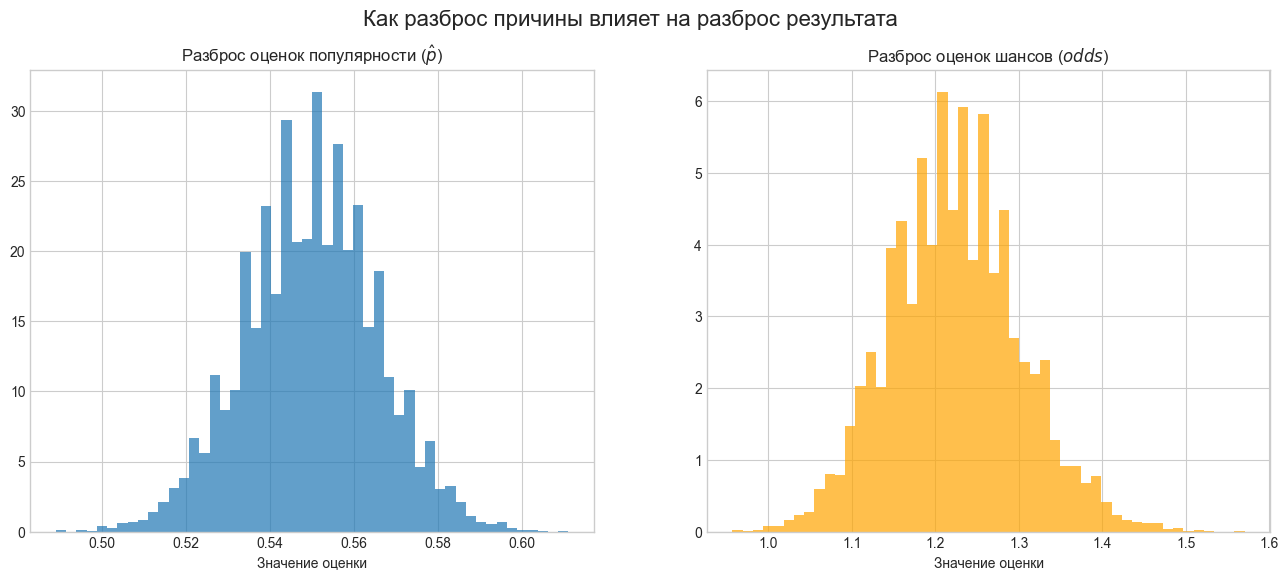

In [3]:
# Параметры нашей симуляции
n_trials = 1000  # 1000 человек в каждом опросе
p_true = 0.55    # Истинная популярность кандидата
n_simulations = 10000 # Проведем 10,000 симуляций опросов

# Проводим симуляции
successes = np.random.binomial(n_trials, p_true, n_simulations)
p_hat_values = successes / n_trials
odds_values = p_hat_values / (1 - p_hat_values)

# Визуализируем оба разброса
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.hist(p_hat_values, bins=50, density=True, alpha=0.7)
ax1.set_title('Разброс оценок популярности ($\hat{p}$)')
ax1.set_xlabel('Значение оценки')

ax2.hist(odds_values, bins=50, density=True, alpha=0.7, color='orange')
ax2.set_title('Разброс оценок шансов ($odds$)')
ax2.set_xlabel('Значение оценки')

plt.suptitle('Как разброс причины влияет на разброс результата', fontsize=16)
plt.show()

Мы видим, что изначальный разброс оценок популярности (слева) породил новый разброс для оценок шансов (справа). Дельта-метод позволяет нам математически вычислить параметры правого графика (его среднее и разброс), зная только параметры левого.

## Производящая функция моментов (MGF): "ДНК" случайности

Представьте, что у каждого вида животных есть уникальный код ДНК. Изучив ДНК, можно узнать всё о животном: какого оно вида и какие у него будут средние характеристики (рост, вес и т.д.).

> **Производящая функция моментов (MGF) — это как уникальный ДНК-код для распределения случайной величины.**

*   У нормального распределения своя MGF, у распределения Пуассона — своя, и они не совпадают.
*   "Расшифровав" MGF (взяв от нее производные), можно получить все важные числовые характеристики распределения: среднее, дисперсию и т.д. (они называются "моментами").

**Но главная суперсила MGF проявляется при сложении независимых случайных величин.**

### Практический пример: Поток покупателей в магазине

Представьте себе большой супермаркет с двумя входами.
*   Через **Вход 1** в среднем заходит 10 покупателей в минуту. Поток покупателей хорошо описывается распределением Пуассона.
*   Через **Вход 2** в среднем заходит 15 покупателей в минуту. Этот поток независим от первого и также описывается распределением Пуассона.

**Вопрос:** Каким будет распределение **общего** числа покупателей, входящих в магазин за минуту?

Интуиция подсказывает, что среднее будет $10 + 15 = 25$. Но будет ли само распределение по-прежнему распределением Пуассона?

MGF дает на этот вопрос элегантный и строгий ответ. Она гласит:
> **"ДНК" суммы = "ДНК" первого * "ДНК" второго**

Математики уже посчитали, что если перемножить "ДНК" двух Пуассоновских распределений, то получится "ДНК" нового Пуассоновского распределения, у которого среднее просто равно сумме исходных средних.

Это происходит потому, что MGF основана на экспоненте, а главное свойство экспоненты (`e^(a+b) = e^a * e^b`) как раз и превращает сложение случайных величин в умножение их функций.

Давайте проверим этот красивый теоретический результат с помощью симуляции. Мы сгенерируем данные для каждого входа и посмотрим на распределение их суммы.

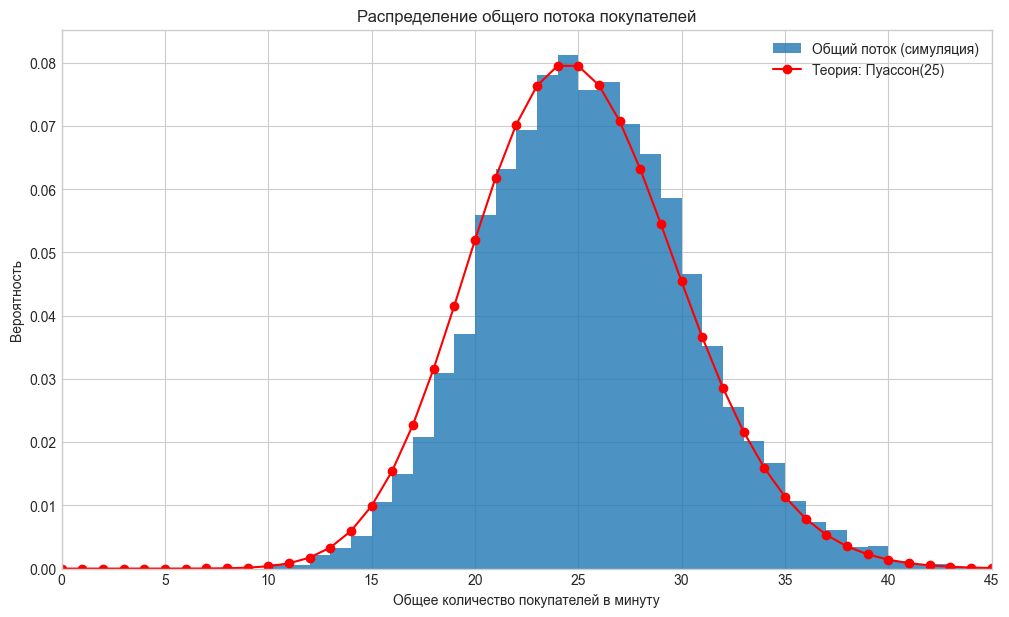

In [4]:
# Параметры
lambda1 = 10  # Среднее для Входа 1
lambda2 = 15  # Среднее для Входа 2
n_minutes = 10000 # Симулируем 10,000 минут работы магазина

# Генерируем случайные данные для каждого входа
buyers_door1 = np.random.poisson(lambda1, n_minutes)
buyers_door2 = np.random.poisson(lambda2, n_minutes)

# Считаем общую сумму для каждой минуты
total_buyers = buyers_door1 + buyers_door2

# --- Визуализация ---
plt.figure(figsize=(12, 7))
# Гистограмма нашей симуляции
plt.hist(total_buyers, bins=range(50), density=True, alpha=0.8, label='Общий поток (симуляция)')

# Теоретический результат: распределение Пуассона со средним 10 + 15 = 25
lambda_total = lambda1 + lambda2
x_values = np.arange(50)
pmf_poisson_total = stats.poisson.pmf(x_values, lambda_total)

# Накладываем теорию на график
plt.plot(x_values, pmf_poisson_total, 'ro-', label=f'Теория: Пуассон({lambda_total})')

plt.title('Распределение общего потока покупателей')
plt.xlabel('Общее количество покупателей в минуту')
plt.ylabel('Вероятность')
plt.legend()
plt.xlim(0, 45)
plt.show()

Результаты симуляции ложатся на теоретическую кривую. Это подтверждает, что сумма двух Пуассоновских процессов — это тоже Пуассоновский процесс. MGF позволяет доказать это без симуляций.

Но есть нюанс:) Это утверждение верно для большинства распределений, с которыми сталкиваются на практике (нормальное, Пуассона, экспоненциальное, биномиальное и т.д.). Существует теорема единственности, которая гласит: если у двух случайных величин совпадают производящие функции моментов, и эти функции существуют в некотором интервале вокруг нуля, то и распределения этих величин совпадают.

Главное условие — существование MGF. Есть распределения, для которых MGF не существует (например, распределение Коши или логнормальное распределение). Для них аналогия с "ДНК" не работает, и для их идентификации используют более мощный инструмент — характеристическую функцию, которая существует всегда.

## Характеристическая функция: Всесильный старший брат MGF

**Характеристическая функция** — это как MGF, но еще круче.

Представьте, что ДНК-тест (MGF) работает для 99% живых существ, но для некоторых экзотических глубоководных созданий он не дает результата. Вам нужен более универсальный тест.

> **Характеристическая функция — это универсальный ДНК-тест, который работает для АБСОЛЮТНО любого распределения.**

Она решает ту же задачу, что и MGF (однозначно определяет распределение и помогает находить его характеристики), но делает это с помощью "магии" комплексных чисел. Из-за этого она всегда существует и всегда работает.

В прикладном анализе данных вы чаще будете слышать про MGF, но в глубокой теоретической статистике именно характеристическая функция является основным и самым строгим инструментом.

### Почему она сложнее для визуализации?

1.  **Выход — комплексное число:** Результат характеристической функции $\phi_X(t) = E[e^{itX}]$ — это комплексное число. У него есть действительная часть (Real) и мнимая часть (Imaginary). Поэтому для одного графика нам нужно строить сразу две кривые.
2.  **Связь с преобразованием Фурье:** Характеристическая функция, по сути, является преобразованием Фурье для функции плотности вероятности. Это мощный инструмент из мира обработки сигналов, но его интуиция сложнее, чем у обычной экспоненты.

### Практический пример: распределение Коши

Давайте возьмем распределение Коши. Оно интересно тем, что у него настолько "тяжелые" хвосты (вероятность экстремальных значений не так уж мала), что для него **не существует ни среднего, ни дисперсии, ни MGF**. Обычный "ДНК-тест" на нем не работает.

А характеристическая функция — работает! Давайте посмотрим на нее.

<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\p'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:37: SyntaxWarning: invalid escape sequence '\p'
C:\Temp\ipykernel_11144\3582742114.py:28: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('Real($\phi(t)$)')
C:\Temp\ipykernel_11144\3582742114.py:37: SyntaxWarning: invalid escape sequence '\p'
  plt.ylabel('Imag($\phi(t)$)')


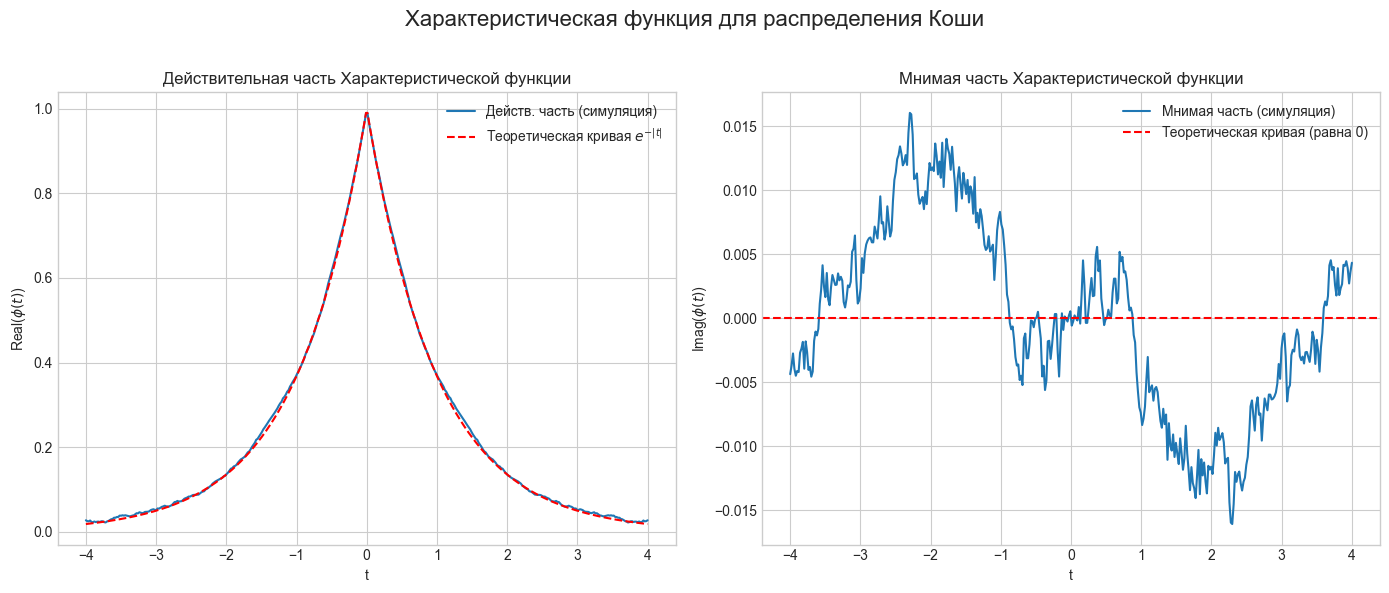

In [5]:
# Возьмем 10000 случайных чисел из распределения Коши
# У него нет ни среднего, ни дисперсии!
cauchy_data = np.random.standard_cauchy(size=10000)

# Эмпирическая характеристическая функция (простое усреднение)
def empirical_char_func(t, data):
    # e^(itx) = cos(tx) + i*sin(tx) по формуле Эйлера
    return np.mean(np.exp(1j * t * data))

# Диапазон для t
t_range = np.linspace(-4, 4, 400)
# Вычисляем значения функции
ecf_values = [empirical_char_func(t, cauchy_data) for t in t_range]

# Теоретическая характеристическая функция для стандартного Коши: phi(t) = e^(-|t|)
# Она, к счастью, действительная и не имеет мнимой части.
theoretical_cf = np.exp(-np.abs(t_range))

# Визуализация
plt.figure(figsize=(14, 6))

# График 1: Действительная часть
plt.subplot(1, 2, 1)
plt.plot(t_range, np.real(ecf_values), label='Действ. часть (симуляция)')
plt.plot(t_range, theoretical_cf, 'r--', label='Теоретическая кривая $e^{-|t|}$')
plt.title('Действительная часть Характеристической функции')
plt.xlabel('t')
plt.ylabel('Real($\phi(t)$)')
plt.legend()

# График 2: Мнимая часть
plt.subplot(1, 2, 2)
plt.plot(t_range, np.imag(ecf_values), label='Мнимая часть (симуляция)')
plt.axhline(0, color='r', linestyle='--', label='Теоретическая кривая (равна 0)')
plt.title('Мнимая часть Характеристической функции')
plt.xlabel('t')
plt.ylabel('Imag($\phi(t)$)')
plt.legend()

plt.suptitle('Характеристическая функция для распределения Коши', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Даже для такого 'проблемного' распределения, как Коши, мы можем построить его уникальный 'ДНК-код' с помощью характеристической функции. Результаты симуляции хорошо совпадают с теоретическими кривыми.